In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
import textdescriptives as td
import textstat
from catboost import CatBoostRegressor, Pool
from datasets import load_dataset
from pandarallel import pandarallel
from scipy.stats import kendalltau, spearmanr
from sklearn.metrics import ndcg_score
from sklearn.model_selection import train_test_split
from textacy.text_stats import basics, counts, diversity, readability

from poetry_ranking.utils import get_sentence_embedding_bert

In [ ]:
regenerate = False

if regenerate:
    import spacy
    import textdescriptives as td
    import textstat
    from pandarallel import pandarallel
    from textacy.text_stats import basics, counts, diversity, readability

    pandarallel.initialize(progress_bar=True, nb_workers=8)
    spacy_nlp = spacy.load("ru_core_news_lg")
    textstat.set_lang("ru")

In [ ]:
def get_textstat_features(text: str):
    return {
        "flesch_reading_ease": textstat.flesch_reading_ease(text),
        "flesch_kincaid_grade": textstat.flesch_kincaid_grade(text),
        "gunning_fog": textstat.gunning_fog(text),
        "smog_index": textstat.smog_index(text),
        "automated_readability_index": textstat.automated_readability_index(text),
        "coleman_liau_index": textstat.coleman_liau_index(text),
        "linsear_write_formula": textstat.linsear_write_formula(text),
        "dale_chall_readability_score": textstat.dale_chall_readability_score(text),
        "text_standard": textstat.text_standard(text),
        "spache_readability": textstat.spache_readability(text),
        "mcalpine_eflaw": textstat.mcalpine_eflaw(text),
        "reading_time": textstat.reading_time(text, ms_per_char=14.69),
        "syllable_count": textstat.syllable_count(text),
        "lexicon_count": textstat.lexicon_count(text, removepunct=True),
        "sentence_count": textstat.sentence_count(text),
        "char_count": textstat.char_count(text, ignore_spaces=True),
        "letter_count": textstat.letter_count(text, ignore_spaces=True),
        "polysyllabcount": textstat.polysyllabcount(text),
        "monosyllabcount": textstat.monosyllabcount(text),
        "difficult_words": textstat.difficult_words(text),
    }


def get_textacy_features(text: str):
    doc = spacy_nlp(text)

    stats = {
        # Basic Statistics
        "n_sents": basics.n_sents(doc),
        "n_words": basics.n_words(doc),
        "n_unique_words": basics.n_unique_words(doc),
        "n_chars_per_word_mean": np.mean(basics.n_chars_per_word(doc)).item(),
        "n_chars": basics.n_chars(doc),
        "n_long_words": basics.n_long_words(doc),
        "n_syllables_per_word_mean": np.mean(basics.n_syllables_per_word(doc)).item(),
        "n_syllables": basics.n_syllables(doc),
        "n_monosyllable_words": basics.n_monosyllable_words(doc),
        "n_polysyllable_words": basics.n_polysyllable_words(doc),
        "entropy": basics.entropy(doc),
        # Readability Measures
        "readability_automated_readability_index": readability.automated_readability_index(
            doc
        ),
        "readability_coleman_liau_index": readability.coleman_liau_index(doc),
        "readability_flesch_kincaid_grade_level": readability.flesch_kincaid_grade_level(
            doc
        ),
        "readability_flesch_reading_ease": readability.flesch_reading_ease(doc),
        "readability_gunning_fog_index": readability.gunning_fog_index(doc),
        "readability_smog_index": readability.smog_index(doc),
        "readability_lix": readability.lix(doc),
        # Diversity Measures
        "diversity_ttr": diversity.ttr(doc),
        "diversity_log_ttr": diversity.log_ttr(doc),
        "diversity_segmented_ttr": diversity.segmented_ttr(doc),
        "diversity_mtld": diversity.mtld(doc),
        "diversity_hdd": diversity.hdd(doc).item(),
        # Counts
        "morph_counts": counts.morph(doc),
        "pos_counts": counts.pos(doc),
        "tag_counts": counts.tag(doc),
        "dep_counts": counts.dep(doc),
    }

    for category, counts_ in stats["morph_counts"].items():
        for subcategory, count in counts_.items():
            stats[f"morph_counts_{category}_{subcategory}"] = count

    # Process pos_counts
    for pos, count in stats["pos_counts"].items():
        stats[f"pos_counts_{pos}"] = count

    # Process tag_counts
    for tag, count in stats["tag_counts"].items():
        stats[f"tag_counts_{tag}"] = count

    # Process dep_counts
    for dep, count in stats["dep_counts"].items():
        stats[f"dep_counts_{dep}"] = count

    stats.pop("morph_counts")
    stats.pop("pos_counts")
    stats.pop("tag_counts")
    stats.pop("dep_counts")

    return stats


def make_features(df):
    df = df.copy()

    df_td = td.extract_metrics(text=df["output_text"], lang="ru", metrics=None)
    df = pd.concat([df, df_td], axis=1)

    df_textstat = df["output_text"].parallel_apply(get_textstat_features).apply(pd.Series)
    df = pd.concat([df, df_textstat], axis=1)

    df_textacy = df["output_text"].parallel_apply(get_textacy_features).apply(pd.Series)
    df = pd.concat([df, df_textacy], axis=1)

    return df

In [ ]:
if regenerate:
    df_train = pd.read_csv("data/raw/poetry_data_train.zip")
    df_test = pd.read_csv("data/raw/poetry_data_test.zip")

    df_train_features = make_features(df_train)
    df_train_features.to_csv(
        "data/text_features/df_train_text_features.zip",
        index=False,
        compression={
            "method": "zip",
            "compresslevel": 9,
            "archive_name": "df_train_text_features.csv",
        },
    )

    df_test_features = make_features(df_test)
    df_test_features.to_csv(
        "data/text_features/df_test_text_features.zip",
        index=False,
        compression={
            "method": "zip",
            "compresslevel": 9,
            "archive_name": "df_test_text_features.csv",
        },
    )

else:
    df_train_features = pd.read_csv("data/text_features/df_train_text_features.zip")
    df_test_features = pd.read_csv("data/text_features/df_test_text_features.zip")

In [ ]:
regenerate_embeddings = False
if regenerate_embeddings:
    from poetry_ranking.utils import get_sentence_embedding_bert

    embeddings = df_train_features["output_text"].apply(
        lambda x: get_sentence_embedding_bert(x)
    )
    embedding_df = pd.DataFrame(
        embeddings.tolist(),
        columns=[f"embedding_{i}" for i in range(embeddings.iloc[0].shape[0])],
    )
    df_train_features = pd.concat([df_train_features, embedding_df], axis=1)
    df_train_features.to_csv(
        "data/bert_embeddings/df_train_embeddings.zip",
        index=False,
        compression={
            "method": "zip",
            "compresslevel": 9,
            "archive_name": "df_train_embeddings.csv",
        },
    )

    embeddings = df_test_features["output_text"].apply(
        lambda x: get_sentence_embedding_bert(x)
    )
    embedding_df = pd.DataFrame(
        embeddings.tolist(),
        columns=[f"embedding_{i}" for i in range(embeddings.iloc[0].shape[0])],
    )
    df_test_features = pd.concat([df_test_features, embedding_df], axis=1)
    df_test_features.to_csv(
        "data/bert_embeddings/df_test_embeddings.zip",
        index=False,
        compression={
            "method": "zip",
            "compresslevel": 9,
            "archive_name": "df_test_embeddings.csv",
        },
    )
else:
    df_train_features = pd.read_csv("data/bert_embeddings/df_train_embeddings.zip")
    df_test_features = pd.read_csv("data/bert_embeddings/df_test_embeddings.zip")

In [ ]:
df_train_features = df_train_features.dropna(axis=1)
df_train_features = df_train_features.loc[:, df_train_features.nunique() > 1]
df_train_features = df_train_features.drop(["url", "text"], axis=1)
df_train_features["text_standard"] = (
    df_train_features["text_standard"]
    .str.extractall(r"(\d+)")
    .unstack()
    .astype(float)
    .mean(axis=1)
)

df_train_features = df_train_features.drop("passed_quality_check", axis=1)
temp_genre_value_counts = df_train_features["genre"].value_counts()
df_train_features["genre"] = df_train_features["genre"].apply(
    lambda x: x if temp_genre_value_counts[x] >= 50 else "Другое"
)
df_train_features = df_train_features.drop("output_text", axis=1)

In [ ]:
def score(rating, views):
    if views == 0:
        return 0
    return views + np.exp(1 + rating / (rating + views)) * rating

In [ ]:
df_train_features["target"] = df_train_features.apply(
    lambda x: score(x["rating"], x["views"]), axis=1
)
df_train_features["target"] = df_train_features["rating"]

In [ ]:
df_train_features = df_train_features.drop(["rating", "views"], axis=1)
df_train_features = df_train_features.drop(["genre"], axis=1)

In [ ]:
class KendallTauMetric:
    def get_final_error(self, error, weight):
        # Return the average Kendall's tau across all batches
        return error / (weight + 1e-38)

    def is_max_optimal(self):
        # Higher Kendall's tau is better
        return True

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        # Calculate Kendall's tau for the current batch
        tau, _ = kendalltau(target, approx)

        # Use tau as the error term and set weight to 1 to accumulate tau scores correctly
        error_sum = tau
        weight_sum = 1.0  # Assign a constant weight to accumulate the Kendall tau values

        return error_sum, weight_sum


X = df_train_features.drop("target", axis=1)
y = df_train_features["target"]


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_pool = Pool(data=X_train, label=y_train, group_id=np.zeros(len(y_train), dtype=int))
val_pool = Pool(data=X_val, label=y_val, group_id=np.zeros(len(y_val), dtype=int))

model = CatBoostRegressor(eval_metric=KendallTauMetric())
model.fit(
    train_pool,
    # text_features=["output_text"],
    eval_set=val_pool,
    early_stopping_rounds=500,
)

y_pred = model.predict(X_val)
# mse = root_mean_squared_error(y_val, y_pred)
# print(f"Root mean Squared Error: {mse}")

/home/seara/Desktop/Github/poetry-ranking/.venv/lib/python3.11/site-packages/catboost/core.py:2321: UserWarning: Failed to import numba for optimizing custom metrics and objectives
  _check_train_params(params)


Learning rate set to 0.10662
0:	learn: 0.1724740	test: 0.1637787	best: 0.1637787 (0)	total: 150ms	remaining: 2m 29s
1:	learn: 0.1787750	test: 0.1710421	best: 0.1710421 (1)	total: 247ms	remaining: 2m 3s
2:	learn: 0.1825589	test: 0.1755413	best: 0.1755413 (2)	total: 360ms	remaining: 1m 59s
3:	learn: 0.1864880	test: 0.1804667	best: 0.1804667 (3)	total: 466ms	remaining: 1m 56s
4:	learn: 0.1879536	test: 0.1818431	best: 0.1818431 (4)	total: 585ms	remaining: 1m 56s
5:	learn: 0.1898295	test: 0.1830087	best: 0.1830087 (5)	total: 686ms	remaining: 1m 53s
6:	learn: 0.1910402	test: 0.1837006	best: 0.1837006 (6)	total: 782ms	remaining: 1m 50s
7:	learn: 0.1917468	test: 0.1845399	best: 0.1845399 (7)	total: 874ms	remaining: 1m 48s
8:	learn: 0.1937622	test: 0.1865887	best: 0.1865887 (8)	total: 973ms	remaining: 1m 47s
9:	learn: 0.1950318	test: 0.1874207	best: 0.1874207 (9)	total: 1.07s	remaining: 1m 45s
10:	learn: 0.1959568	test: 0.1885131	best: 0.1885131 (10)	total: 1.16s	remaining: 1m 44s
11:	learn: 0.

In [ ]:
# # Example true scores and predicted scores
# true_scores = np.array([30000, 20000, 40000, 10000, 500])  # True poem scores (0 to 80k)
# predicted_scores = np.array([250, 35000, 45000, 15000, 55000])  # Predicted poem scores (0 to 80k)
# y_pred = filled_array = np.full(y_val.shape, np.mean(y_val))
# Rank the scores
true_rankings = np.argsort(-y_val)  # Higher scores get lower ranks (0 is the highest)
predicted_rankings = np.argsort(-y_pred)
constant_array = np.full(y_val.shape, np.mean(y_val))
noise = np.random.uniform(-1, 1, y_val.shape)
noisy_array = constant_array + noise
# # 1. Mean Average Precision (MAP)
# # Since MAP requires binary relevance for a ranked list, we will use an approach to convert scores to relevance
# # Here we assume any score above a certain threshold is relevant; for simplicity, we consider all as relevant
# relevance_true = (true_scores > 0).astype(int)  # Convert to binary relevance (1 if score > 0)
# average_precision = average_precision_score(relevance_true, predicted_scores)
# print(f"Mean Average Precision: {average_precision}")

# 2. Normalized Discounted Cumulative Gain (NDCG)
# We need to reshape true_scores and predicted_scores for ndcg_score
ndcg = ndcg_score([true_rankings], [predicted_rankings], k=100000000)
print(f"NDCG: {ndcg}")

# 3. Kendall's Tau
kendall_tau, _ = kendalltau(y_val, y_pred)
print(f"Kendall's Tau: {kendall_tau}")

# 4. Spearman's Rank Correlation Coefficient
spearman_corr, _ = spearmanr(y_val, y_pred)
print(f"Spearman's Rank Correlation: {spearman_corr}")

NDCG: 0.938846577480855
Kendall's Tau: 0.20779810138560442
Spearman's Rank Correlation: 0.2797183071117315


In [ ]:
pandarallel.initialize(progress_bar=True, nb_workers=8)
spacy_nlp = spacy.load("ru_core_news_lg")
textstat.set_lang("ru")


esenin = """Вы помните,
Вы всё, конечно, помните,
Как я стоял,
Приблизившись к стене,
Взволнованно ходили вы по комнате
И что-то резкое
В лицо бросали мне.

Вы говорили:
Нам пора расстаться,
Что вас измучила
Моя шальная жизнь,
Что вам пора за дело приниматься,
А мой удел —
Катиться дальше, вниз.

Любимая!
Меня вы не любили.
Не знали вы, что в сонмище людском
Я был как лошадь, загнанная в мыле,
Пришпоренная смелым ездоком."""

llm_stuff = """Лучи пробиваются сквозь облака,
Ветры гуляют в рассветном просторе,
Свет разливается нежно, слегка,
И сердце свободно, как волны на море.

Тихо струится роса по траве,
Солнце играет в хрустальных каплях,
Мысли, как птицы, взмывают к весне,
В мире из звуков и красок, без тайн.

Лес оживает в прохладной тиши,
Тропы зовут меня вглубь неведомо,
Ветви качнутся, шуршание листвы —
Душа моя с природой слита едино."""

llm_stuff_2 = """В лесу растёт большой дубок,
На нём сидит весёлый сок,
Листья шепчут, птицы поют,
А рядом мышка в траве прячется вдруг.

Светит солнце, яркий день,
Старый кот нашёл тень.
Греет лапы, спит он крепко,
Снится, как ловит рыбку мелкую.

Река течёт, шумит вода,
Плывёт на ней бумажка — ура!
Рыбки плещутся, как в сказке,
Но вдруг налетает стая ласки.

Скоро вечер, ночь придёт,
Луна на небе ярко бьёт.
Все уснули, лес в тишине,
Сон приходит, светит огне."""

df_seara = pd.DataFrame({"output_text": [esenin, llm_stuff, llm_stuff_2]})

df_seara = make_features(df_seara)


embeddings = df_seara["output_text"].apply(lambda x: get_sentence_embedding_bert(x))
embedding_df = pd.DataFrame(
    embeddings.tolist(),
    columns=[f"embedding_{i}" for i in range(embeddings.iloc[0].shape[0])],
)
df_seara = pd.concat([df_seara, embedding_df], axis=1)


# df_seara = df_seara.dropna(axis=1)
# df_seara = df_seara.loc[:, df_seara.nunique() > 1]
df_seara["text_standard"] = (
    df_seara["text_standard"]
    .str.extractall(r"(\d+)")
    .unstack()
    .astype(float)
    .mean(axis=1)
)

# df_seara = df_seara.drop("passed_quality_check", axis=1)
df_seara = df_seara.drop("output_text", axis=1)

df_seara.to_csv(
    "data/penis.zip",
    index=False,
    compression={
        "method": "zip",
        "compresslevel": 9,
        "archive_name": "penis.csv",
    },
)
df_seara = pd.read_csv("data/penis.zip")

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/home/seara/Desktop/Github/poetry-ranking/.venv/lib/python3.11/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'ru_core_news_lg' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


ℹ No spacy model provided. Inferring spacy model for ru.
⚠ Could not load lexeme probability table for language ru. This will
result in NaN values for perplexity and entropy.


/home/seara/Desktop/Github/poetry-ranking/.venv/lib/python3.11/site-packages/textdescriptives/components/coherence.py:44: UserWarning: [W008] Evaluating Span.similarity based on empty vectors.
  similarities.append(sent.similarity(sents[i + order]))


/home/seara/Desktop/Github/poetry-ranking/.venv/lib/python3.11/site-packages/textstat/textstat.py:1489: Warning: There is no easy words vocabulary for ru, using english.
  warnings.warn(
/home/seara/Desktop/Github/poetry-ranking/.venv/lib/python3.11/site-packages/textstat/textstat.py:1489: Warning: There is no easy words vocabulary for ru, using english.
  warnings.warn(
/home/seara/Desktop/Github/poetry-ranking/.venv/lib/python3.11/site-packages/textstat/textstat.py:1489: Warning: There is no easy words vocabulary for ru, using english.
  warnings.warn(


In [ ]:
df_seara = df_seara[X_train.columns]

In [ ]:
esenin_pred = model.predict(df_seara)

In [ ]:
esenin_pred

array([ 8.54917106,  9.64379346, 11.71739441])

In [ ]:
dataset = load_dataset("IlyaGusev/stihi_ru", split="train")

stihi_ru.jsonl.zst:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5151050 [00:00<?, ? examples/s]

In [ ]:
feature_importance_df.head(50)

,Feature,Importance
44,pos_prop_ADP,3.973756
607,embedding_500,3.763321
462,embedding_355,3.352067
600,embedding_493,2.348303
316,embedding_209,1.953292
659,embedding_552,1.708700
525,embedding_418,1.424982
49,pos_prop_INTJ,1.380439
15,duplicate_ngram_chr_fraction_5,1.334128
535,embedding_428,1.116297


             Feature  Importance
44      pos_prop_ADP    3.973756
607    embedding_500    3.763321
462    embedding_355    3.352067
600    embedding_493    2.348303
316    embedding_209    1.953292
..               ...         ...
153     embedding_46    0.000000
142     embedding_35    0.000000
105  dep_counts_ROOT    0.000000
787    embedding_680    0.000000
874    embedding_767    0.000000

[875 rows x 2 columns]


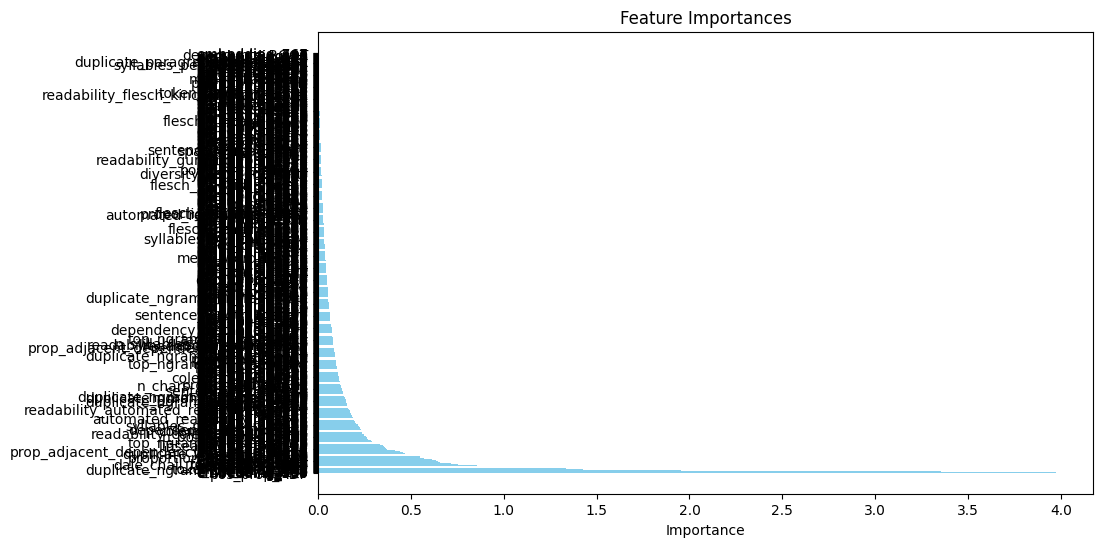

In [ ]:
importances = model.get_feature_importance()

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame(
    {"Feature": X_train.columns, "Importance": importances}
).sort_values(by="Importance", ascending=False)

# Display feature importances
print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(
    feature_importance_df["Feature"], feature_importance_df["Importance"], color="skyblue"
)
plt.xlabel("Importance")
plt.title("Feature Importances")
plt.show()

In [ ]:
y_pred[-20:]

array([-0.3848382 ,  3.47578809, 66.76403764,  3.33553392,  0.31257395,
       22.09144534,  8.43868561,  4.41495301, 35.29768215,  0.99664661,
        8.28171855,  1.2709696 ,  3.79476562,  7.29183643,  1.76548237,
       14.20064152,  3.3535678 ,  0.94031716, 76.93090629,  6.73740289])

In [ ]:
y_val.to_numpy()[-20:]

array([ 0,  8, 85,  7,  0,  0,  0,  0,  7,  7, 40,  0,  1,  0,  0, 24,  0,
       18, 77,  7])

In [ ]:
pd.concat([y_val, y_pred])

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid